## Football Stats

In this project, we will be aiming to predict the `fpl_value` placed on players by Fantasy Premier League, according to a series of statistics held on each player (such as `market_value` and `fpl_sel`. In essence, given a training subset of players, can we predict the `fpl_value` of other players in the validation set?

Let's import the 2017-18 English Premier League dataset and take a brief look at the first five rows.

In [28]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn

from utils import plot_scatter

data = pd.read_csv('data.csv')

data[:5]

,name,club,age,position,position_cat,market_value,page_views,fpl_value,fpl_sel,fpl_points,region,nationality,new_foreign,age_cat,club_id,big_club,new_signing
0,Alexis Sanchez,Arsenal,28,LW,1,65.0,4329,12.0,17.10%,264,3.0,Chile,0,4,1,1,0
1,Mesut Ozil,Arsenal,28,AM,1,50.0,4395,9.5,5.60%,167,2.0,Germany,0,4,1,1,0
2,Petr Cech,Arsenal,35,GK,4,7.0,1529,5.5,5.90%,134,2.0,Czech Republic,0,6,1,1,0
3,Theo Walcott,Arsenal,28,RW,1,20.0,2393,7.5,1.50%,122,1.0,England,0,4,1,1,0
4,Laurent Koscielny,Arsenal,31,CB,3,22.0,912,6.0,0.70%,121,2.0,France,0,4,1,1,0


### Investigation into the dataset

Firstly, let's check to see if the table has any missing values. `isnull()` will also show us the column names, which we will look at when deciding what our features will be.


In [29]:
data.isnull().any()

name            False
club            False
age             False
position        False
position_cat    False
market_value    False
page_views      False
fpl_value       False
fpl_sel         False
fpl_points      False
region           True
nationality     False
new_foreign     False
age_cat         False
club_id         False
big_club        False
new_signing     False
dtype: bool

`region` has some missing values. Let's see how many.

In [30]:
data[data.isnull().any(axis=1)]

,name,club,age,position,position_cat,market_value,page_views,fpl_value,fpl_sel,fpl_points,region,nationality,new_foreign,age_cat,club_id,big_club,new_signing
188,Steve Mounie,Huddersfield,22,CF,1,5.5,56,6.0,0.60%,0,NaN,Benin,0,2,8,0,0


There is one row with a missing value, which is convenient as we don't need to figure out how to fill it in - we will represent Mounie's `region` with the number `4` as he is from Benin, which would be categorised as the "rest of the world" according to this dataset.

In [31]:
data.fillna(4, inplace=True) 
data.iloc[188]['region']

4.0

Now, we'll create graphs to check the correlation between the variable we are predicting, `market_value` and the other columns - starting with `club`.

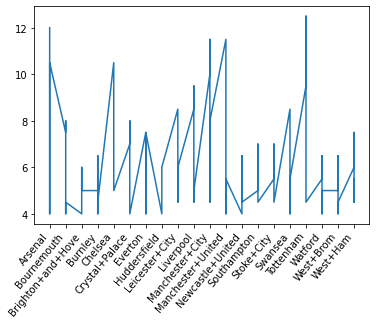

In [32]:
fig, ax = plt.subplots()
ax.plot(
    data['club'], data['fpl_value']
)
plt.setp(ax.get_xticklabels(), rotation=50, horizontalalignment='right')
plt.show()

As we can see from the graph above, players generally have a higher value for Arsenal, Chelsea, Liverpool, Man City, Man Utd and Tottenham - we can just use the `big_club` column as a feature later on.

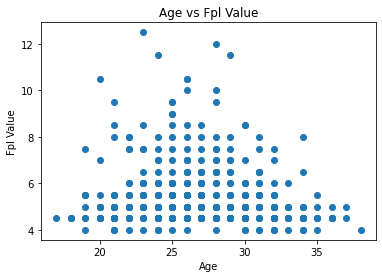

In [33]:
plot_scatter(data, 'age', 'fpl_value')

`age` isn't so clear, but we can see that players below 20 and players above 34 generally have a tighter range of values.

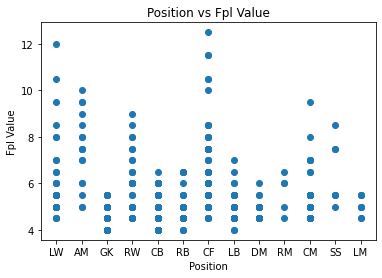

In [34]:
plot_scatter(data, 'position', 'fpl_value')

In terms of `fpl_value`, we can see that CF, SS, LW, RW, AM, CM are generally the highest valued players.

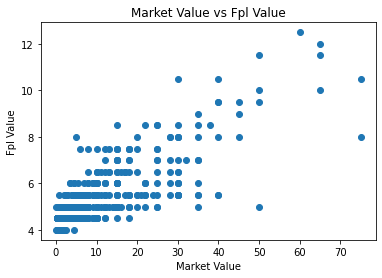

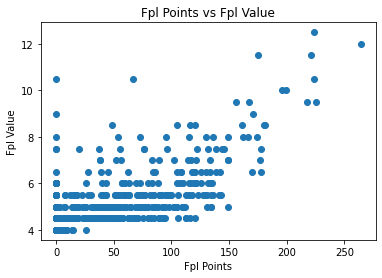

In [35]:
plot_scatter(data, 'market_value', 'fpl_value')
plot_scatter(data, 'fpl_points', 'fpl_value')

There is a more clear correlation with both `market_value` and `fpl_points` although in the case of the latter, we can see a few more outliers on 0 points. I would think the reason why some players who achieved 0 points last season is that they are new to FPL and thus priced according to other statistics (such as performance in other leagues).

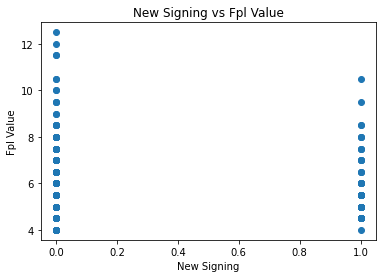

In [36]:
plot_scatter(data, 'new_signing', 'fpl_value')

There isn't a clear distinction between new signings and FPL value.